# Decentralized Federated Learning Simulation

**Implementation of decentralized FL without parameter server**
- Network topologies: Ring, Star, Small World
- MNIST dataset with IID distribution  
- Parameter aggregation: `(1-ρ) × old + ρ × neighbor_avg`

In [1]:
# Import necessary libraries for decentralized federated learning simulation
import torch

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')


from topology import NetworkTopology
from visualize import plot_topology, plot_interactive_topology, plot_heatmap
from partitioner import DataDistributor
from client import DecentralizedClient
from distributed import run_decentralized_fl


# Autoupdate the notebook to reflect changes in the imported modules
%load_ext autoreload
%autoreload 2

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


print("Libraries imported")

Libraries imported


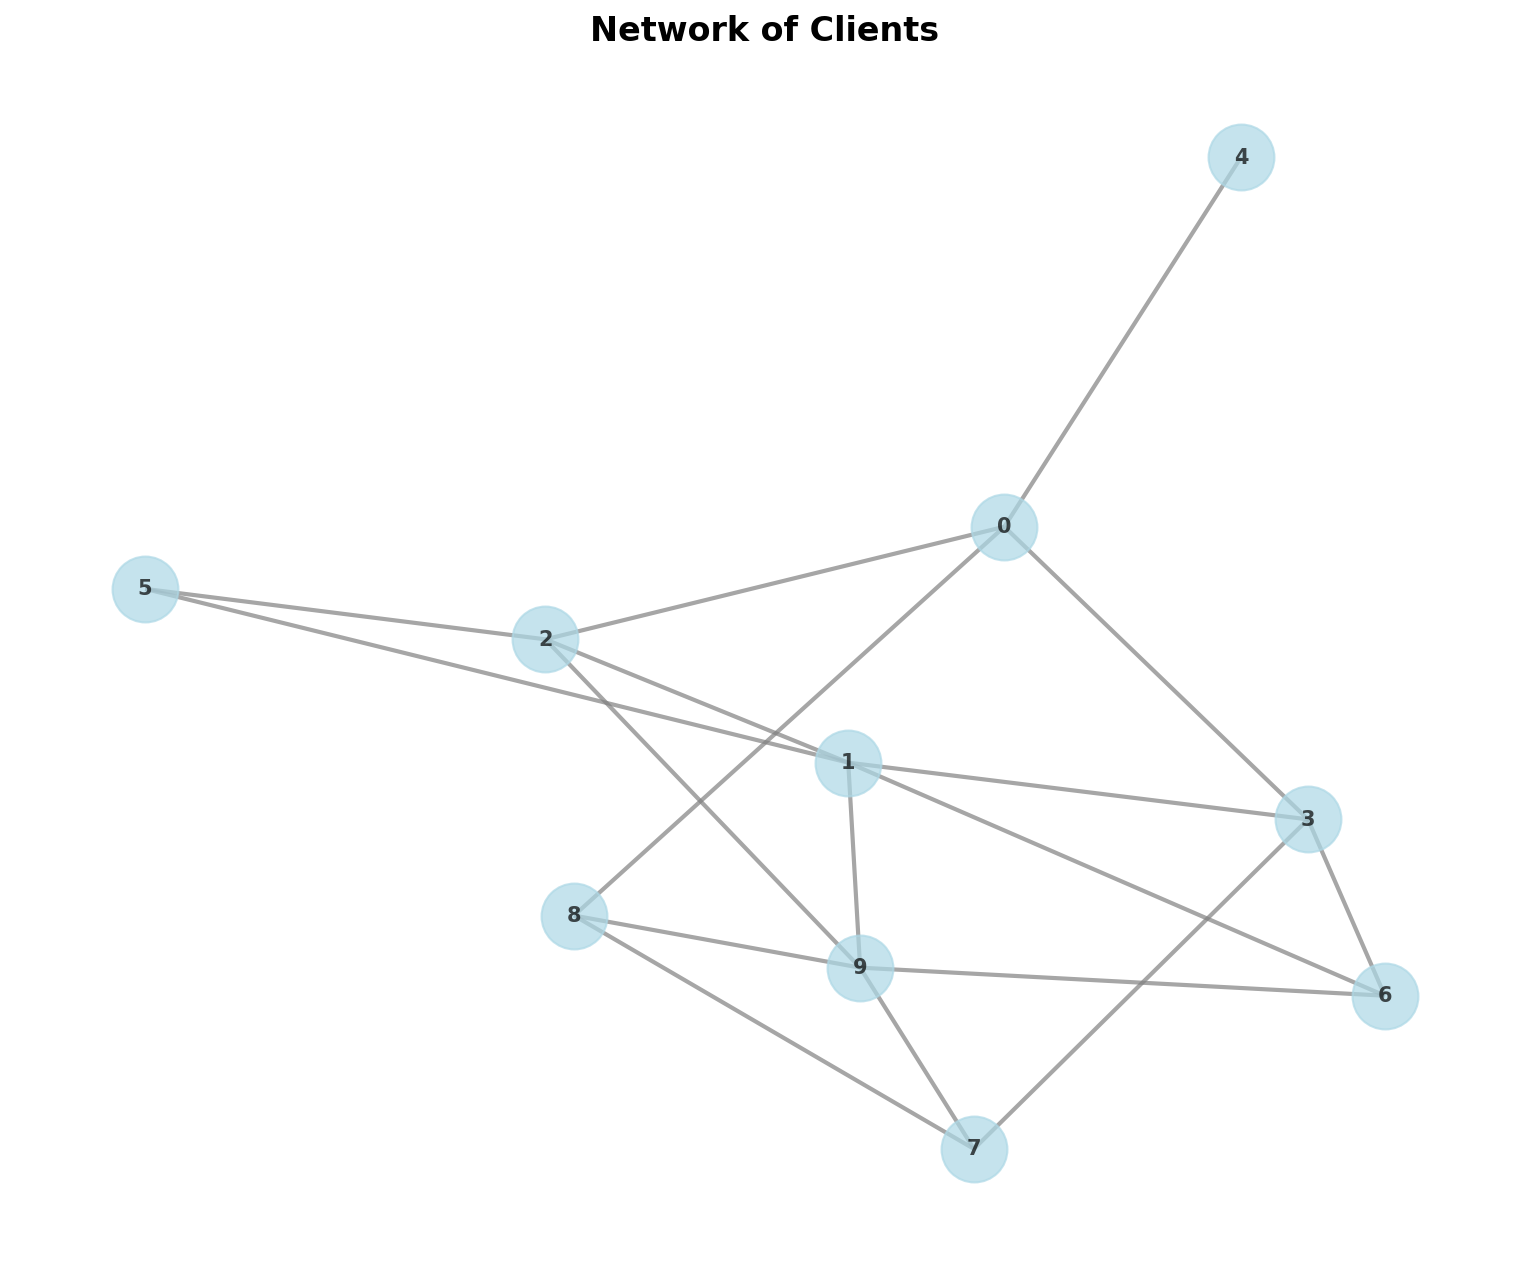

{'topology': 'random',
 'num_nodes': 10,
 'num_edges': 17,
 'density': 0.37777777777777777,
 'average_degree': 3.4,
 'min_degree': 1,
 'max_degree': 5,
 'most_frequent_degree': 3,
 'diameter': 3,
 'clustering_coefficient': 0.35333333333333333,
 'is_connected': True}

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Generate a topology
network = NetworkTopology(num_clients=10)
network.create_topology()#(k=4, p=0.1)

# Plot ropology
plot_topology(network.G, file_name='test_top')

network.get_topology_info()

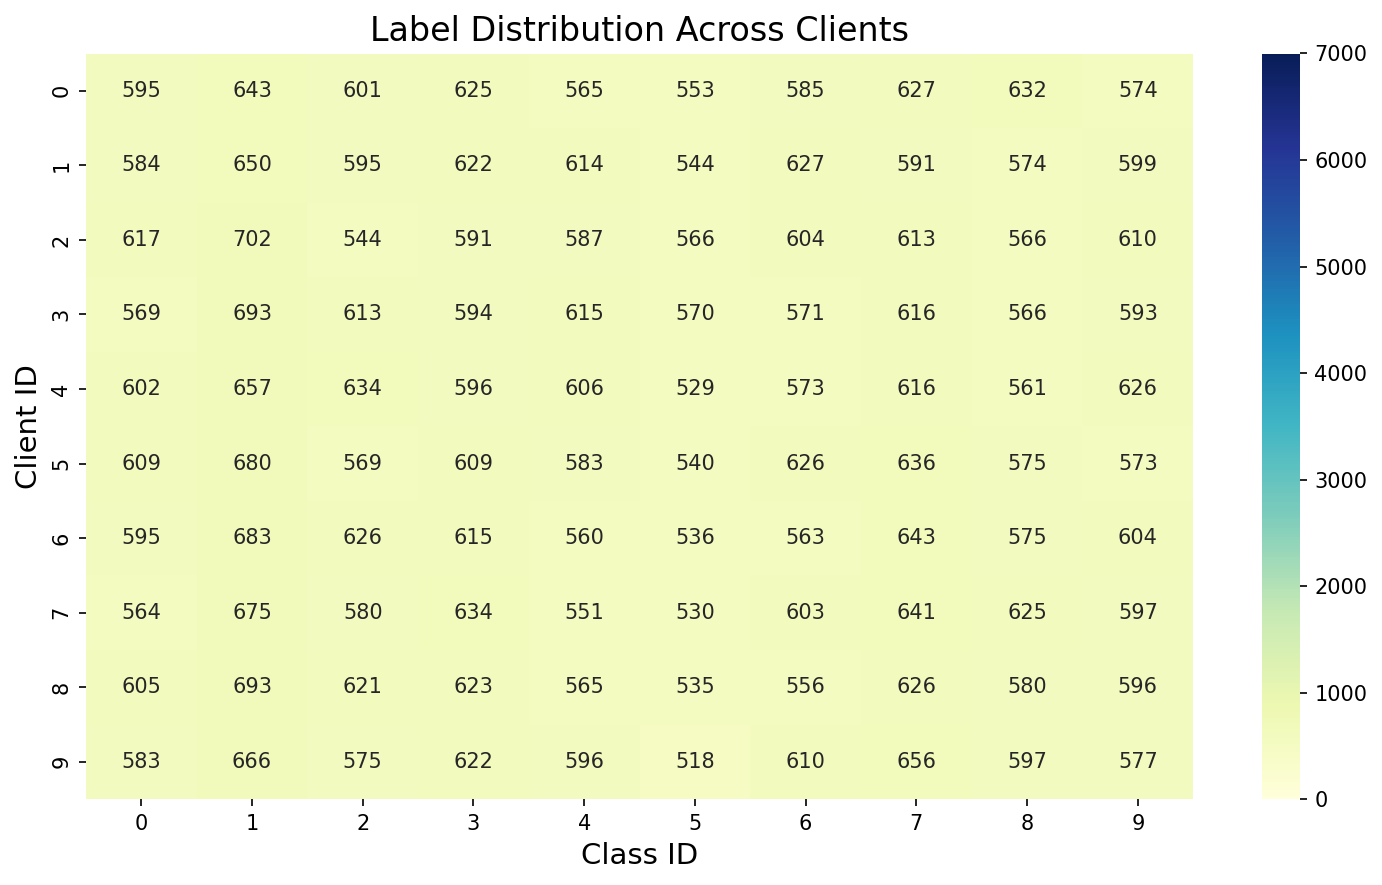

In [3]:
# Setup data distribution
data_distributor = DataDistributor(num_clients=10, name='mnist', partition='iid', alpha=0.3, verbose=False)
data_distributor.load_and_distribute()
summary = data_distributor.get_data_summary()
plot_heatmap(data_distributor.client_data, file_name='test_distr')

In [4]:
L = nx.normalized_laplacian_matrix(network.G)
L_norm = L.toarray()

# Compute eigenvectors and eigenvalues
eigenvalues1, eigenvectors = np.linalg.eig(L_norm)
print(eigenvalues1)


A = nx.adjacency_matrix(network.G).toarray()

[-2.22044605e-16  1.76825591e+00  4.45642544e-01  5.34808055e-01
  7.35972753e-01  1.59698864e+00  1.40275992e+00  1.24375104e+00
  1.27182114e+00  1.00000000e+00]


In [5]:
from scipy.linalg import eigh  # for eigen-decomposition
from scipy.sparse import csgraph

# --- 2. Compute Laplacian ---
L = csgraph.laplacian(A, normed=False)  # unnormalized Laplacian

# --- 3. Eigen-decomposition ---
# Compute first k eigenvectors/eigenvalues
k = 20  # number of eigenvectors to keep
eigvals, eigvecs = eigh(L)  # L is symmetric, returns sorted eigenvalues

# Keep first k eigenvectors (excluding the zero eigenvalue if desired)
eigvals = eigvals[1:k+1]        # skip first trivial eigenvalue 0
eigvecs = eigvecs[:, 1:k+1]

# --- 4. Heat/diffusion kernel ---
t = 10 # diffusion time, small = local, large = global
heat_kernel = eigvecs @ np.diag(np.exp(-t * eigvals)) @ eigvecs.T

# --- 5. Convert kernel to similarity matrix ---
similarity_matrix = heat_kernel
print("Similarity between nodes 0 and 1:", similarity_matrix[0,1])

# Optional: normalize similarities to [0,1]
similarity_matrix = similarity_matrix / similarity_matrix.max()

Similarity between nodes 0 and 1: -1.6991523395903116e-05


In [8]:
similarity_matrix.shape

(10, 10)

In [6]:
L_norm = nx.normalized_laplacian_matrix(network.G).toarray()

# Step 3: Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(L_norm)

# Normalize eigenvectors
eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=0)

# Step 4: Sort eigenvalues and corresponding eigenvectors
idx = np.argsort(eigenvalues)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Step 5: Choose embedding dimension (e.g., k=3)
k = 5
# Skip all the  eigenvalues≈0 (mb not just the first one)
#node_embeddings = eigenvectors[:, 1:k+1]  # Skip first eigenvector (≈0 eigenvalue)
node_embeddings = eigenvectors[:, np.where(eigenvalues > 1e-5)[0][:k]]  # Skip all eigenvectors with ≈0 eigenvalue

print("Node embeddings shape:", node_embeddings.shape)
node_embeddings

Node embeddings shape: (10, 5)


array([[-5.09822428e-01,  3.54328645e-01, -9.29572364e-02,
        -1.22277517e-17,  1.63435553e-01],
       [ 4.06468595e-01,  1.09832973e-01, -1.59743782e-01,
         2.27681519e-16, -3.99677603e-01],
       [ 2.05300412e-01,  3.80346580e-01,  3.17830847e-01,
        -3.04129791e-16,  6.16383775e-01],
       [-4.42644555e-02, -1.69913807e-01, -5.30742036e-01,
        -4.71404521e-01,  2.52668570e-01],
       [-4.59831849e-01,  3.80841337e-01, -1.76037203e-01,
         2.35702260e-01, -3.35250992e-01],
       [ 3.62800771e-01,  3.63731703e-01,  2.34274131e-01,
        -3.33333333e-01, -3.75528324e-01],
       [ 2.12315119e-01, -2.05340250e-01, -4.73897094e-01,
         4.08248290e-01, -2.28967658e-02],
       [-1.70648437e-01, -4.60404983e-01,  1.92711621e-01,
        -4.08248290e-01, -2.24015066e-02],
       [-3.22046888e-01, -2.70885923e-01,  4.04271591e-01,
        -5.67048948e-16, -3.09951100e-01],
       [ 9.88647819e-02, -2.89821118e-01,  2.68536983e-01,
         5.27046277e-01

In [7]:
# Compute similarity between clients based on their embeddings
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(node_embeddings)
similarity_matrix

array([[ 1.        , -0.56012554,  0.19108728,  0.10558669,  0.68454028,
        -0.28405731, -0.31336094, -0.22569046, -0.04673635, -0.35202302],
       [-0.56012554,  1.        , -0.34937947, -0.11346631,  0.03796201,
         0.65958021,  0.3565881 , -0.35278214, -0.25475312, -0.2197362 ],
       [ 0.19108728, -0.34937947,  1.        , -0.13707023, -0.34834698,
         0.09039887, -0.35229279, -0.2983451 , -0.4291275 ,  0.1456302 ],
       [ 0.10558669, -0.11346631, -0.13707023,  1.        , -0.25449975,
        -0.23939643,  0.14711185,  0.32980659, -0.45498841, -0.59087347],
       [ 0.68454028,  0.03796201, -0.34834698, -0.25449975,  1.        ,
        -0.03944995,  0.02228251, -0.4413358 ,  0.15771962, -0.24733615],
       [-0.28405731,  0.65958021,  0.09039887, -0.23939643, -0.03944995,
         1.        , -0.45159578, -0.07879119, -0.00853816, -0.45602247],
       [-0.31336094,  0.3565881 , -0.35229279,  0.14711185,  0.02228251,
        -0.45159578,  1.        , -0.43119878

In [8]:
A = nx.adjacency_matrix(network.G).toarray()
A

array([[0, 0, 1, 1, 1, 0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0, 1, 1, 0, 0, 1],
       [1, 1, 0, 0, 0, 1, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 1, 1, 0, 0, 0, 1, 1, 1, 0]])

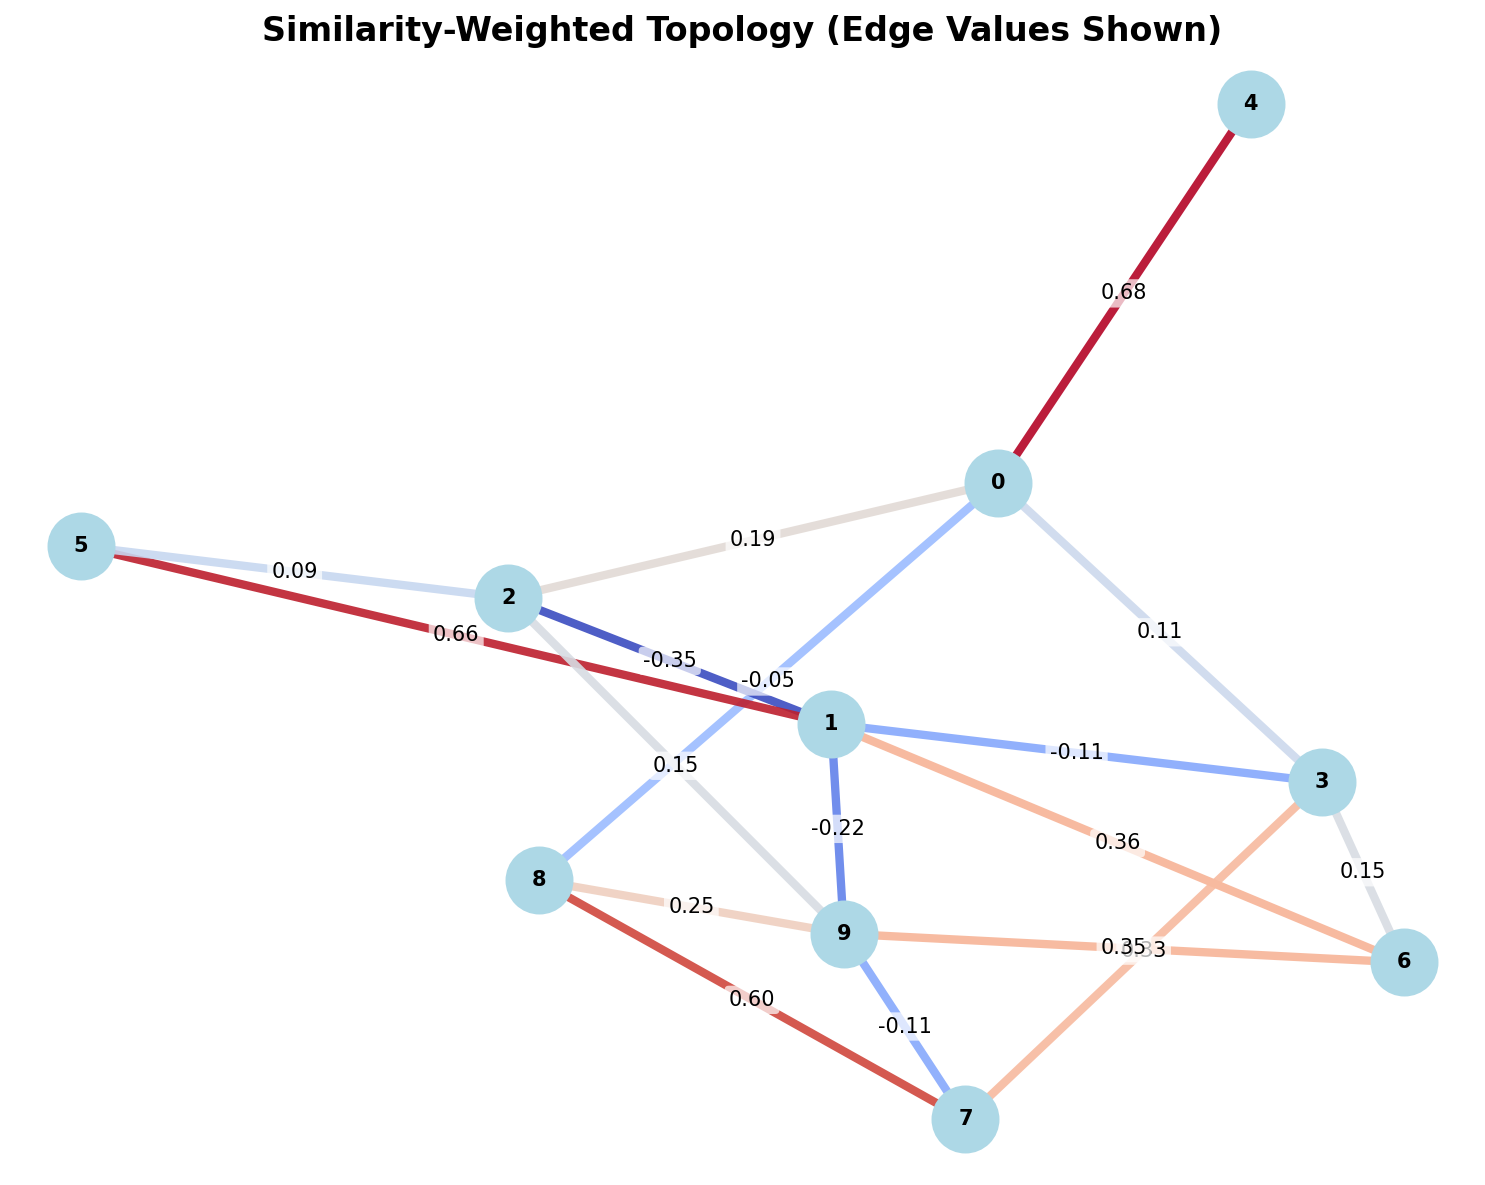

In [ ]:
# Plot topology, weighting links by highlighting similar nodes through links color
A_tilde = A * similarity_matrix
plot_topology(network.G, Adj=A_tilde, file_name='test_top_weighted')

In [18]:
# Get weight of a link {2-3}
A_tilde[3, 7]

np.float64(0.32980659054764794)

In [19]:
A_tilde

array([[ 0.        , -0.        ,  0.19108728,  0.10558669,  0.68454028,
        -0.        , -0.        , -0.        , -0.04673635, -0.        ],
       [-0.        ,  0.        , -0.34937947, -0.11346631,  0.        ,
         0.65958021,  0.3565881 , -0.        , -0.        , -0.2197362 ],
       [ 0.19108728, -0.34937947,  0.        , -0.        , -0.        ,
         0.09039887, -0.        , -0.        , -0.        ,  0.1456302 ],
       [ 0.10558669, -0.11346631, -0.        ,  0.        , -0.        ,
        -0.        ,  0.14711185,  0.32980659, -0.        , -0.        ],
       [ 0.68454028,  0.        , -0.        , -0.        ,  0.        ,
        -0.        ,  0.        , -0.        ,  0.        , -0.        ],
       [-0.        ,  0.65958021,  0.09039887, -0.        , -0.        ,
         0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        ,  0.3565881 , -0.        ,  0.14711185,  0.        ,
        -0.        ,  0.        , -0.        

In [20]:
A_tilde[1, 3]

np.float64(-0.11346630933383962)

In [23]:
# Make node 5 select 2 neighbors

node = 5
selection_ratio = 0.5

neighbours = list(network.G.neighbors(node))
print(list(neighbours))

# Get edge weight of the neighbors
edge_weights = [A_tilde[node, i] for i in neighbours]
print(edge_weights)

# Use softmax 
#probabilities = np.exp(edge_weights) / np.sum(np.exp(edge_weights))
#print(probabilities, sum(probabilities))
# Normalize
probabilities = edge_weights / np.sum(edge_weights)
print(probabilities, sum(probabilities))
#assert sum(probabilities) == 1.0

np.random.choice(neighbours, int(len(neighbours) * selection_ratio), replace=False, p=probabilities)

[1, 2]
[np.float64(0.6595802137546907), np.float64(0.09039886810746525)]
[0.87946481 0.12053519] 1.0


array([1])

In [21]:
# Test Different Selection Strategies

print("Comparing Selection Strategies on Ring Topology:")

print("\n1. All neighbors (100%):")
results_all = run_decentralized_fl('ring', num_clients=6, num_rounds=2, local_epochs=1, rho=0.2,
                                 selection_strategy='all', selection_ratio=1.0)

print("\n2. Random 50% neighbors:")  
results_50 = run_decentralized_fl('ring', num_clients=6, num_rounds=2, local_epochs=1, rho=0.2,
                                selection_strategy='random', selection_ratio=0.5)

print("\n3. Random 25% neighbors:")
results_25 = run_decentralized_fl('ring', num_clients=6, num_rounds=2, local_epochs=1, rho=0.2,
                                selection_strategy='random', selection_ratio=0.25)

print(f"\nSelection Strategy Comparison (Final Accuracy):")
print(f"All neighbors:  {results_all[-1]['accuracy']:.1f}%")
print(f"50% neighbors:  {results_50[-1]['accuracy']:.1f}%") 
print(f"25% neighbors:  {results_25[-1]['accuracy']:.1f}%")

Comparing Selection Strategies on Ring Topology:

1. All neighbors (100%):
Selection: all (100% of neighbors)


AttributeError: 'str' object has no attribute 'neighbors'

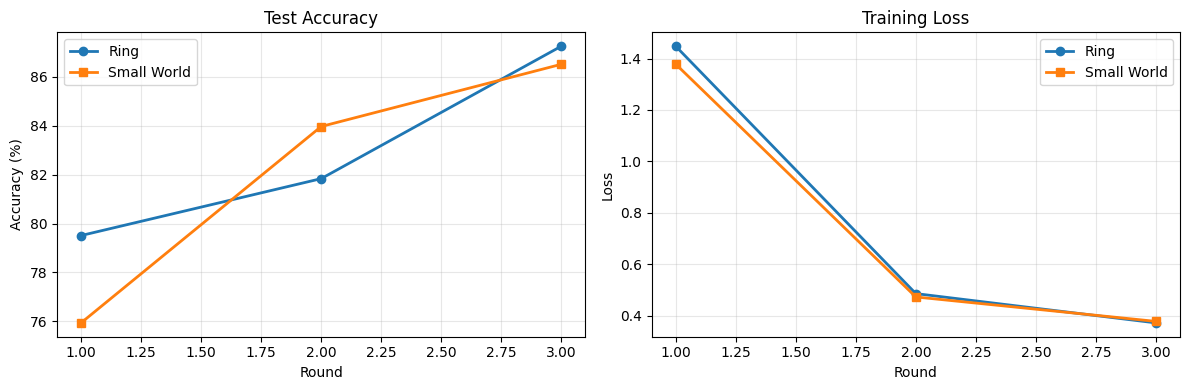

Decentralized FL Complete - Ring: 87.3%, Small World: 86.5%


In [ ]:
# Results Visualization

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Extract data
rounds_ring = [r['round'] for r in results_ring]
acc_ring = [r['accuracy'] for r in results_ring]
loss_ring = [r['loss'] for r in results_ring]

rounds_sw = [r['round'] for r in results_sw]
acc_sw = [r['accuracy'] for r in results_sw]
loss_sw = [r['loss'] for r in results_sw]

# Accuracy plot
ax1.plot(rounds_ring, acc_ring, 'o-', label='Ring', linewidth=2)
ax1.plot(rounds_sw, acc_sw, 's-', label='Small World', linewidth=2)
ax1.set_xlabel('Round')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Test Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(rounds_ring, loss_ring, 'o-', label='Ring', linewidth=2)
ax2.plot(rounds_sw, loss_sw, 's-', label='Small World', linewidth=2)
ax2.set_xlabel('Round')
ax2.set_ylabel('Loss')
ax2.set_title('Training Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Decentralized FL Complete - Ring: {results_ring[-1]['accuracy']:.1f}%, Small World: {results_sw[-1]['accuracy']:.1f}%")

## 3-Phase Decentralized FL Communication

### **Phase 1: Client Selection**
- `select_neighbors()`: Each client selects subset of neighbors  
- Strategies: `'random'` (with ratio), `'all'`
- Extensible for future strategies (distance-based, performance-based, etc.)

### **Phase 2: Model Transmission** 
- `transmit_to_selected()`: Selected clients send models
- `receive_model()`: Clients store incoming models
- Asynchronous communication simulation

### **Phase 3: Model Aggregation**
- `aggregate_received_models()`: Combine own + received models
- Formula: `(1-ρ) × own_model + ρ × avg_received_models`
- Clear received models after aggregation